# Model Creation

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import requests
import urllib.request as urllib
from PIL import Image
from io import BytesIO

import torch
from torchvision.io import read_image
from torchvision import transforms, models
import torch.nn.functional as F
import torch.nn as nn

## Create: Classification network

In [2]:
weights = models.MobileNet_V3_Small_Weights.DEFAULT
classification_model = models.mobilenet_v3_small(weights=weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\User/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100.0%


In [3]:
preprocess = weights.transforms()
classification_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## Test: Classification Network

In [4]:
def process_img_from_path(img_path):
  img = read_image(img_path)
  x = preprocess(img).unsqueeze(0)
  return x

def process_img_from_array(img_array):
  x = preprocess(img_array).unsqueeze(0)
  return x

def process_img_from_PIL(img):
  x = transforms.ToTensor()(img)
  x = preprocess(x).unsqueeze(0)
  return x

In [5]:
x = process_img_from_path("test_imgs/cat.jpg")

c:\Users\User\OneDrive\Desktop\literally everything\code\projects\Image Search Engine\server_pytorch\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
# Predict the class probabilities
prediction = classification_model(x).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Egyptian cat: 35.4%


## Create: Siamese network

In [7]:
base_net = models.mobilenet_v3_small(weights=weights)

# Remove the fully connected layer (classification head)
base_net = nn.Sequential(*list(base_net.children())[:-1])

# Set the model to evaluation mode
base_net.eval()

# Forward pass through the model
embeddings = base_net(x)

# Print the output tensor
print(embeddings.shape)

torch.Size([1, 576, 1, 1])


In [8]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()

    self.net = base_net

  def forward_once(self, x):
    return self.net(x)

  def forward(self, input1, input2):
    # calculate embeddings
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)

    # calculate euclidean distance
    dist = torch.sum(F.pairwise_distance(output1, output2))
    return dist.item()

siamese_model = SiameseNetwork()

## Test: Siamese Network

In [9]:
siamese_model.eval()

SiameseNetwork(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNormAct

In [10]:
dog = process_img_from_path("test_imgs/dog.jpg")
dog2 = process_img_from_path("test_imgs/dog2.jpg")
cat = process_img_from_path("test_imgs/cat.jpg")
cat2 = process_img_from_path("test_imgs/cat2.jpg")

dog.shape, dog2.shape, cat.shape, cat2.shape

(torch.Size([1, 3, 224, 224]),
 torch.Size([1, 3, 224, 224]),
 torch.Size([1, 3, 224, 224]),
 torch.Size([1, 3, 224, 224]))

Same class comparisons:

In [11]:
siamese_model(dog, dog2)

206.6648712158203

In [12]:
siamese_model(cat, cat2)

203.96353149414062

Different class comparisons:

In [13]:
siamese_model(dog, cat)

329.5746154785156

In [14]:
siamese_model(dog, cat2)

361.8633117675781

In [15]:
siamese_model(dog2, cat)

338.45770263671875

In [16]:
siamese_model(dog2, cat2)

364.199462890625

It is clear that a lower similarity score is attained when images of the same class are compared and a higher similarity score is attained when images of different classes are compared.

The lower the similarity score, the more similar the images are.

# Setup Data Fetching

## Setup: Unsplash API

In [17]:
client_id = "1Rb3JZ4ZLqv1ps70yBqjxmpvWkoOeORD2mnh5UekJGk"

In [18]:
def fetch_imgs(keyword, n_pages=3):
  img_urls = []
  for i in range(1, n_pages+1):
    url = f"https://api.unsplash.com/search/photos?page={i}&query={keyword}&client_id={client_id}"
    results = requests.get(url).json()["results"]
    for x in results:
      img_urls.append(x["urls"]["small"])
  return img_urls

In [19]:
def load_img_from_url(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  return image

## Test: Unsplash API

In [20]:
img_urls = fetch_imgs("labrador", 1)
img_urls

['https://images.unsplash.com/photo-1529831129093-0fa4866281ee?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHwxfHxsYWJyYWRvcnxlbnwwfHx8fDE2ODY2NDc2MjF8MA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1586671267731-da2cf3ceeb80?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHwyfHxsYWJyYWRvcnxlbnwwfHx8fDE2ODY2NDc2MjF8MA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1561495376-dc9c7c5b8726?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHwzfHxsYWJyYWRvcnxlbnwwfHx8fDE2ODY2NDc2MjF8MA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1537204696486-967f1b7198c8?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHw0fHxsYWJyYWRvcnxlbnwwfHx8fDE2ODY2NDc2MjF8MA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1619276511528-f397bf25e13d?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHw1fHxsYWJyYWRvcnxlbnwwfHx8fDE2ODY2NDc2MjF

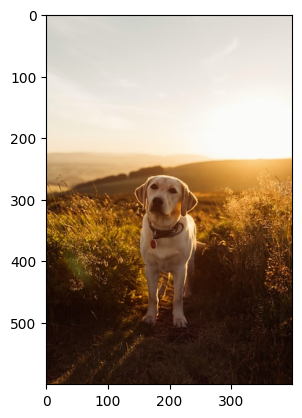

In [21]:
img = load_img_from_url(img_urls[0])
plt.imshow(img)
plt.show()

# Simulate API request

Given an input image, we will do the following steps:
1. Classify it through the classification model
2. Retrieve 50 images of this classification using the Unsplash API
3. Use the Siamese network to determine the top 20 similar images of these 50 images
4. Return these 20 images

## Load an input image

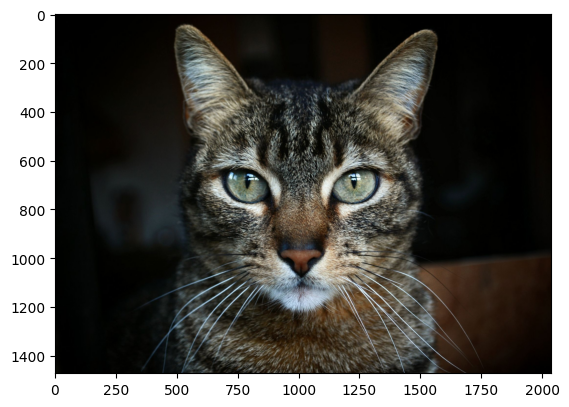

In [22]:
x = load_img_from_url("https://www.thesprucepets.com/thmb/o76tYUlS1kJCb8H9VCyL4249ayo=/2036x1473/filters:fill(auto,1)/GettyImages-584178259-5a721010119fa80037ed3cce.jpg")
plt.imshow(x)
plt.show()

## Classification

In [23]:
x = process_img_from_PIL(x)

In [24]:
# Predict the class probabilities
prediction = classification_model(x).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

tabby: 46.0%


## Retrieve comparison images

In [25]:
img_urls = fetch_imgs(category_name, n_pages=5)
print(f"{len(img_urls)} images retrieved.")

50 images retrieved.


## Compare images using siamese network

In [26]:
sims = []

for index, img_url in enumerate(img_urls):
  img = load_img_from_url(img_url)
  img = process_img_from_array(img)
  sim_score = siamese_model(x, img)
  sims.append({
      "comp": img,
      "url": img_url,
      "sim_score": sim_score,
  })
  print(f"Image {index} done.")

Image 0 done.
Image 1 done.
Image 2 done.
Image 3 done.
Image 4 done.
Image 5 done.
Image 6 done.
Image 7 done.
Image 8 done.
Image 9 done.
Image 10 done.
Image 11 done.
Image 12 done.
Image 13 done.
Image 14 done.
Image 15 done.
Image 16 done.
Image 17 done.
Image 18 done.
Image 19 done.
Image 20 done.
Image 21 done.
Image 22 done.
Image 23 done.
Image 24 done.
Image 25 done.
Image 26 done.
Image 27 done.
Image 28 done.
Image 29 done.
Image 30 done.
Image 31 done.
Image 32 done.
Image 33 done.
Image 34 done.
Image 35 done.
Image 36 done.
Image 37 done.
Image 38 done.
Image 39 done.
Image 40 done.
Image 41 done.
Image 42 done.
Image 43 done.
Image 44 done.
Image 45 done.
Image 46 done.
Image 47 done.
Image 48 done.
Image 49 done.


## Find top 20 similar images

In [27]:
# Sort images by similarity score

sims.sort(key=lambda x: x["sim_score"])

In [28]:
# Get top 20 similar images

sim_images = sims[:20]
sim_images = [x["url"] for x in sim_images]

In [29]:
sim_images

['https://images.unsplash.com/photo-1549295264-617dec805276?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHwxNXx8dGFiYnl8ZW58MHx8fHwxNjg2NzMwMjAxfDA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1616044543567-a31e09b178ee?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHwxfHx0YWJieXxlbnwwfHx8fDE2ODY3MzAyMDF8MA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1474743437114-94141802864e?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHw0OHx8dGFiYnl8ZW58MHx8fHwxNjg2NzMwMjAzfDA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1616589050164-7dbe2ed3fe17?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHw4fHx0YWJieXxlbnwwfHx8fDE2ODY3MzAyMDF8MA&ixlib=rb-4.0.3&q=80&w=400',
 'https://images.unsplash.com/photo-1648170723309-46a266549e73?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=M3w0NjAxMzZ8MHwxfHNlYXJjaHw0Nnx8dGFiYnl8ZW58MHx8fHwxNjg2NzMwMjAzfDA&ixlib=rb-4.0.

This list of image urls is what the API will return.

# Serialization

In [30]:
torch.jit.script(classification_model).save('classification_api/models/classification_model.pt')

In [31]:
torch.jit.script(siamese_model).save('similarity_api/models/siamese_model.pt')